### TODO: run method -> classify; next method (not loop over all methods)

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import decoupler as dc
import mudata as mu

In [2]:
from scipy.sparse import csr_matrix

In [3]:
from liana.funcomics import obsm_to_adata

In [4]:
data_dir = '../../data/heart_visium'

#### Load data

In [5]:
adata = sc.read_h5ad(os.path.join(data_dir, 'AKK002_157781.h5ad'))

In [6]:
compositions = obsm_to_adata(adata, 'compositions')

In [7]:
compositions.var

""
Adipo
CM
Endo
Fib
Lymphoid
Mast
Myeloid
Neuronal
PC
prolif


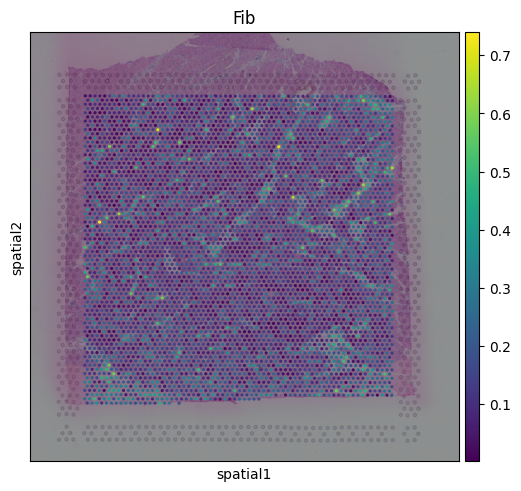

In [8]:
sq.pl.spatial_scatter(compositions, color="Fib")

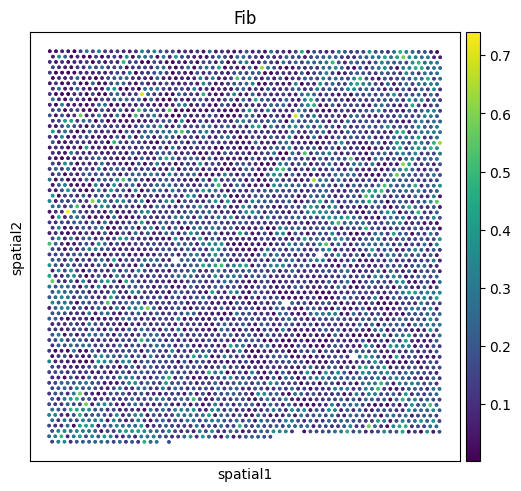

In [9]:
sq.pl.spatial_scatter(compositions, shape=None, color="Fib", size=10)

#### Filter & normalize

In [10]:
sc.pp.filter_cells(adata, min_genes=400)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

#### Get Spatial Neighbors

In [ ]:
sq.gr.spatial_neighbors(adata, n_rings=1, coord_type="grid", n_neighs=6)

#### Infer LR

In [ ]:
## NOTE: I should change basis to 'bivariate'
from liana.mt.sp import lr_basis
from liana.mt.sp import basis

In [ ]:
adata.X

In [ ]:
lr_basis(adata,
        function_name="masked_pearson",
        expr_prop=0.1,
        pvalue_method=None, 
        use_raw=False, 
        #  positive_only:True,
        proximity_key="spatial_connectivities",
)

In [ ]:
lr_basis(adata,
        function_name="pearson",
        expr_prop=0.1,
        pvalue_method=None, 
        use_raw=False, 
        obsm_added ="vec_pearson",
        #  positive_only:True,
        proximity_key="spatial_connectivities",
)

## Transcription Factors

In [ ]:
net = dc.get_dorothea(organism='human', levels=['A','B','C'])
net

In [ ]:
dc.run_mlm(mat=adata, net=net, source='source', target='target', weight='weight', verbose=True, use_raw=False)

In [ ]:
# NOTE: enable basis to handle adata (i.e. if adata takes OBSM & X as input)
mdata = mu.MuData({'rna' : adata, 'tfs': obsm_to_adata(adata, 'mlm_estimate')})

In [ ]:
mdata.obsm = adata.obsm
mdata.uns = adata.uns
mdata.obsp = adata.obsp

In [ ]:
sq.gr.sepal(mdata.mod['tfs'], max_neighs=6)

In [ ]:
from matplotlib.pyplot import hist

In [ ]:
hist(mdata.mod['tfs'].uns['sepal_score'])

In [ ]:
sepal_scores = mdata.mod['tfs'].uns['sepal_score'].copy()

In [ ]:
tfs_to_keep = (sepal_scores[(sepal_scores > 1.5).values]).index

In [ ]:
mdata.mod['tfs'] = mdata.mod['tfs'][:,tfs_to_keep].copy()

In [ ]:
basis(mdata, x_mod='tfs', y_mod='tfs', function_name='cosine', 
        proximity_key="spatial_connectivities", mod_added='local_tfs')

In [ ]:
mdata.mod['local_tfs'].var

Attempt to predict cell type proportions from local LR scores.

In [ ]:
X = adata.obsm['local_scores'].values
# X = mdata.mod['local_tfs'].X

In [ ]:
adata.obsm['local_scores']

In [ ]:
y = compositions.X

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

In [ ]:
# Assuming X is a 2D array with shape (n_samples, n_features)
# and y is a 2D array with shape (n_samples, n_targets)
X_train, X_test, y_train, y_test = train_test_split(X, y[:,1], test_size=0.2, random_state=1337)


In [ ]:
# Initialize the Random Forest Regressor with default parameters
rf = RandomForestRegressor(n_estimators=100, oob_score=True, n_jobs=-1, random_state=1337)

In [ ]:
# Train the model on the training data
rf.fit(X_train, y_train)

In [ ]:
rf.oob_score_

In [ ]:
# Use the trained model to predict the test data
y_pred = rf.predict(X_test)

In [ ]:
# Calculate the R^2 score as a measure of model performance
r2 = r2_score(y_test, y_pred)
print(f"R^2 score: {r2}")

Are there cell types that are predicted?

In [ ]:
importances = pd.DataFrame(data=rf.feature_importances_, index=adata.obsm['local_scores'].columns, columns=['importance'])

In [ ]:
importances.sort_values('importance', ascending=True)